In [1]:
import sys
sys.path.append('.')

import gym
import numpy as np
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from utils import RAdam

def moving_average(x, N):
    return np.convolve(x, np.ones(N, ), mode='valid') / N

/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Episode 99 finished after 126 timesteps
Episode 199 finished after 299 timesteps
Episode 299 finished after 148 timesteps
Episode 399 finished after 238 timesteps
Episode 499 finished after 135 timesteps
Episode 599 finished after 201 timesteps
Episode 699 finished after 244 timesteps
Episode 799 finished after 135 timesteps
Episode 899 finished after 186 timesteps
Episode 999 finished after 500 timesteps
Episode 1099 finished after 302 timesteps
Episode 1199 finished after 287 timesteps
Episode 1299 finished after 222 timesteps
Episode 1399 finished after 239 timesteps
Episode 1499 finished after 407 timesteps
Episode 99 finished after 18 timesteps
Episode 199 finished after 33 timesteps
Episode 299 finished after 24 timesteps
Episode 399 finished after 109 timesteps
Episode 499 finished after 396 timesteps
Episode 599 finished after 500 timesteps
Episode 699 finished after 161 timesteps
Episode 799 finished after 131 timesteps
Episode 899 finished after 76 timesteps
Episode 999 finis

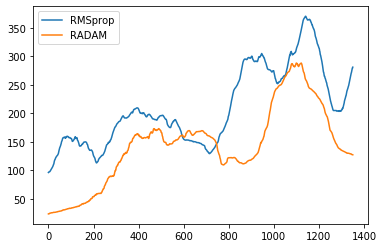

In [2]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []
        self.dones = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

policy = Policy()
optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
# optimizer = RAdam(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
#     print('rewards_arr', rewards_arr)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def reset_globals():
    global policy
    global optimizer
    
    policy = Policy()
    optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)

def train_on_rollout(gamma=0.99):
    returns = discount_rewards(policy.rewards, gamma)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    
def train_on_batch(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.mean().backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    del policy.dones[:]

def learn_n_step_A2C(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 30

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                train_on_batch(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards
N_EPS = 1500
rewards_A2C_RMs_prop = learn_n_step_A2C(N_EPS, 500)
plt.plot(moving_average(rewards_A2C_RMs_prop, 150), label='RMSprop')
# Try out radam
reset_globals()
optimizer = RAdam(policy.parameters(), lr=3e-3)
rewards_A2C_RADAM = learn_n_step_A2C(N_EPS, 500)
plt.plot(moving_average(rewards_A2C_RADAM, 150), label='RADAM')
plt.legend()
plt.show()

## PPO:

<img src="./asd.png" style="width: 70%"> </img>

Episode 99 finished after 17 timesteps
Episode 199 finished after 156 timesteps
Episode 299 finished after 251 timesteps
Episode 399 finished after 500 timesteps
Episode 499 finished after 500 timesteps
Episode 599 finished after 500 timesteps
Episode 699 finished after 500 timesteps
Episode 799 finished after 500 timesteps
Episode 899 finished after 500 timesteps
Episode 999 finished after 500 timesteps
Episode 1099 finished after 500 timesteps
Episode 1199 finished after 500 timesteps
Episode 1299 finished after 500 timesteps
Episode 1399 finished after 500 timesteps
Episode 1499 finished after 160 timesteps
Episode 99 finished after 54 timesteps
Episode 199 finished after 15 timesteps
Episode 299 finished after 16 timesteps
Episode 399 finished after 36 timesteps
Episode 499 finished after 106 timesteps
Episode 599 finished after 22 timesteps
Episode 699 finished after 31 timesteps
Episode 799 finished after 239 timesteps
Episode 899 finished after 281 timesteps
Episode 999 finished

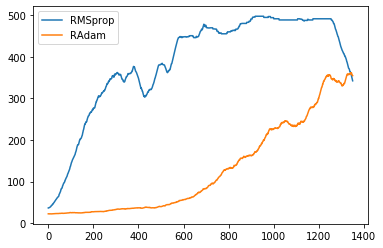

In [5]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.states = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values.squeeze()

policy = Policy()
policy_old = Policy()
policy_old.load_state_dict(policy.state_dict())

optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
# optimizer = RAdam(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def reset_globals():
    global policy
    global policy_old
    global optimizer
    
    policy = Policy()
    policy_old = Policy()
    policy_old.load_state_dict(policy.state_dict())
    
    optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)


def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy_old(state)
    m = Categorical(probs)
    action = m.sample()
    policy.actions.append(action.item())
    policy.logprobs.append(m.log_prob(action).item())
    policy.states.append(state)
#     policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def evaluate_policy(states, old_actions):
    probs, values = policy.forward

def batch_update_agent(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    
    states = torch.stack(policy.states).float()
#     print(states.shape)
    old_actions = policy.actions
#     print(old_actions)
    old_logprobs = torch.tensor(policy.logprobs).float()
#     print(old_logprobs.shape)
    
    # PPO OLD VALUES
    for i in range(2):
        # Calculate needed values    
        p, v = policy.forward(states)
        m = Categorical(p)
        c = m.log_prob(torch.tensor(old_actions))
        entr = m.entropy()

        # value fn loss
        loss_vf = F.mse_loss(v, returns)

        # surrogate loss
        advantage = returns - v.detach()
        r_ts = torch.exp(c - old_logprobs)
        loss_surr = - (torch.min(r_ts * advantage, torch.clamp(r_ts, 1-0.2, 1+0.2) * advantage)).mean()
        
        # maximize entropy bonus
        loss_entropy = - 0.0001 * entr.mean()

        # the total_loss
        loss_total = loss_vf + loss_surr + loss_entropy
        
        # step
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
#         raise Exception('1111')

    policy_old.load_state_dict(policy.state_dict())    
    
    del policy.actions[:]
    del policy.states[:]
    del policy.logprobs[:]
    del policy.rewards[:]
    del policy.dones[:]

def learn_PPO_single_threaded(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 300

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                batch_update_agent(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards

N_EPS = 1500

rewards_PPO = learn_PPO_single_threaded(N_EPS, 500)
plt.plot(moving_average(rewards_PPO, 150), label='RMSprop')

# Try out radam
reset_globals()

optimizer = RAdam(policy.parameters(), lr=3e-3)
rewards_PPO_RAdam = learn_PPO_single_threaded(N_EPS, 500)
plt.plot(moving_average(rewards_PPO_RAdam, 150), label='RAdam')
plt.legend()
plt.show()

### TODO

try to train the model on r + V(x') - V(x) advantage